In [3]:
import pandas as pd
import math
import numpy as np
from sklearn import model_selection
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.spatial import cKDTree
from PCHA import PCHA

In [4]:
import gpflow
from tensorflow import logging
import tensorflow as tf
logging.set_verbosity(logging.WARN)

In [5]:
import random

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

def archetypal_analysis(X, k):
    archetypes = PCHA(X.transpose(), k, conv_crit=1E-3, maxiter=50)[0].transpose()
    tree = cKDTree(X)
    return X[tree.query(archetypes, k=1)[1], :]

In [6]:
def y_transform_fn(value):
    if value < 1800:
        scaled_value = value/3600
    elif value >= 1800 and value <= 7200:
        scaled_value = (value + 3600)/10800
    else:
        scaled_value = value/7200
    return math.log(1+1/scaled_value)


def remove_one_hot(X):
    mappings = {
        'tone': ['tone_1', 'tone_2', 'tone_3'],
        'day_of_week': ['day_of_week_0', 'day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6']
    }
    X_transformed = X[:]
    
    def clean_col_name(element):
        return int(element[-1])
            
    for (col, cols) in mappings.items():
        X_transformed[col] = list(map(clean_col_name, (X.loc[:, cols] == 1).idxmax(1)))
        X_transformed = X_transformed.drop(cols, axis=1)
    
    return X_transformed

In [7]:
X_pd = pd.read_pickle('training_data_X')
y_pd = pd.read_pickle('training_data_y')
X_pd.loc[:, 'sent_to_open_delta'] = X_pd.loc[:, 'sent_to_open_delta'].astype('float16')
X_pd['sent_to_open_delta'] = X_pd['sent_to_open_delta'].apply(pd.to_numeric).apply(y_transform_fn)
X = X_pd.values

int_mask = list(map(int, X_pd['sent_to_open_delta'] > 0))
X_masked = X_pd.loc[X_pd.index[X_pd['sent_to_open_delta'] > 0], :]
y_masked = y_pd.loc[X_pd.index[X_pd['sent_to_open_delta'] > 0]]
X2 = X_masked.values

X_no_open = X_pd.loc[:, X_pd.columns != 'sent_to_open_delta']
X3 = X_no_open.values

y_original = y_pd.values
y_masked_original = y_masked.values

N = len(y_original)
y = np.reshape(np.array(list(map(y_transform_fn, y_original))), (len(y_original), 1))
y2 = np.reshape(np.array(list(map(y_transform_fn, y_masked_original))), (len(y_masked_original), 1))
M1 = len(list(X_pd.columns.values))
M3 = len(list(X_no_open.columns.values))

In [8]:
X_pd.columns.values

array(['end_to_sent_delta', 'last_progress_report_value',
       'last_report_delta', 'package_duration', 'sent_to_open_delta',
       'time_of_day', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'tone_1', 'tone_2', 'tone_3', 'who_assigned_role_owner',
       'who_assigned_role_manager'], dtype=object)

In [9]:
def scale(X, df=X_pd, normalisation=None):
    columns_to_scale = set(['last_report_delta', 'package_duration', 'end_to_sent_delta', 'sent_to_open_delta', 'time_of_day']).intersection(df.columns.values)
    columns_indexes = [df.columns.get_loc(col) for col in columns_to_scale]
    X_transformed = X[:]
    if len(X.shape) == 2 and X.shape[1] > 1:
        if normalisation == None:
            normalisation = StandardScaler().fit(X[:, columns_indexes])
        X_transformed[:, columns_indexes] = normalisation.transform(X[:, columns_indexes])
    else:
        if normalisation == None:
            normalisation = StandardScaler().fit(X)
        X_transformed = normalisation.transform(X)
    
    return X_transformed, normalisation

In [10]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

def run_adam(model, lr, iterations, callback=None):
    adam = AdamOptimizer(lr).make_optimize_action(model)
    actions = [adam] if callback is None else [adam, callback]
    loop = Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())
    
kf = model_selection.KFold(n_splits=10)
N_inducing = 15

def random_initialize(array):
    try:
        myclip_a = 0
        myclip_b = 50
        my_std = 20
        my_mean = 10
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        random_gen = stats.truncnorm(a, b, loc=1.5, scale=2)
        return random_gen.rvs(array.shape)
    except:
        return np.absolute(20 * np.random.randn() + 20)

def set_white_variance(model, variance):
    try:
        for kernel in model.kern.kernels:
            if isinstance(kernel, gpflow.kernels.White):
                kernel.variance = variance
                kernel.variance.trainable = False
    except AttributeError:
        pass
    
def optimize_model(model, opt):
    model.compile()
    if (opt == 'scipy'):
        opt_ = gpflow.train.ScipyOptimizer()
        opt_.minimize(model, anchor=False)
    if (opt == 'adam'):
        run_adam(model, 1e-3, 150)

def model_from_kernel(k, X_, y_, model='gpr', opt='scipy', InducingPoints=None):
    try:
        mean_f = gpflow.mean_functions.Constant(c=y_.min())
        if (model == 'gpr'):
            m = gpflow.models.GPR(X_, y_, kern=k, mean_function=mean_f)
        if (model == 'sgpr' and InducingPoints is not None):
            m = gpflow.models.SGPR(X_, y_, kern=k, Z=InducingPoints, mean_function=mean_f)
        assert m is not None
        set_white_variance(m, 1e-3)
        optimize_model(m, opt)
        went_wrong = False
    except (AttributeError, tf.errors.InvalidArgumentError):
        try:
            if (model == 'gpr'):
                m1 = gpflow.models.GPR(X_, y_, kern=k, mean_function=mean_f)
            if (model == 'sgpr' and InducingPoints is not None):
                m1 = gpflow.models.SGPR(X_, y_, kern=k, Z=InducingPoints, mean_function=mean_f)
            assert m1 is not None
            set_white_variance(m1, 1e-1)
            print('Trying with higher diagonal jitter')
            optimize_model(m1, opt)
            return m1, False
        except (AttributeError, tf.errors.InvalidArgumentError):
            print('The data in this split is not compatible with this kernel.')
            went_wrong = True
    
    return m, went_wrong

def cv_model(k, X_, y_, k_name, model='gpr', opt='scipy', split='kfold'):
    errors = list()
    y_predict_train = list()
    var_predict_train = list()
    y_predict = list()
    var_predict = list()
    models = list()
    
    if (split == 'kfold'):
        split = kf.split(X_)
    elif (split == 'final'):
        N = int(9/10 * X_.shape[0])
        indices = np.random.permutation(X_.shape[0])
        training_idx, test_idx = indices[:N], indices[N:]
        split = [(training_idx, test_idx)]
    elif (split == 'none'):
        split = [(None, None)]
    for train, test in split:
        if (split == 'none'):
            X_train = X_
            y_train = y_
        else:
            X_train, X_test, y_train, y_test = X_[train, :], X_[test, :], y_[train, :], y_[test, :]

        if (X_.shape[1] == 18):
            X_train, input_norm = scale(X_train)
            X_test, _ = scale(X_test, normalisation=input_norm)

            y_train, input_norm_y = scale(y_train)
            y_test, _ = scale(y_test, normalisation=input_norm_y)
        elif (X_.shape[1] == 17):
            X_train, input_norm = scale(X_train, df=X_no_open)
            X_test, _ = scale(X_test, df=X_no_open, normalisation=input_norm)

            y_train, input_norm_y = scale(y_train)
            y_test, _ = scale(y_test, normalisation=input_norm_y)
        
        Z = None
        if (model == 'sgpr'):
            X_and_y = np.c_[X_train, y_train]
            X_medoids = X_train[kMedoids(pairwise_distances(X_and_y), N_inducing, 40)[0], :]
            X_archetypes = archetypal_analysis(X_and_y, N_inducing)[:, :-1]
            Z = np.concatenate(X_medoids, X_archetypes, axis=0)

        errors_for_fold = list()
        
        for i in range(5):
            if isinstance(k, gpflow.kernels.Linear):
                k.variance = random_initialize(k.variance.value)
            if (isinstance(k, gpflow.kernels.RBF) or isinstance(k, gpflow.kernels.Matern32) or isinstance(k, gpflow.kernels.Matern52))  and not isinstance(k.lengthscales.value, float):
                k.lengthscales = random_initialize(k.lengthscales.value)
                k.variance = random_initialize(k.variance.value)
            if hasattr(k, 'kernels'):
                for i in range(len(k.kernels)):
                    if isinstance(k.kernels[i], gpflow.kernels.Linear):
                        k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)
                    if isinstance(k.kernels[i], gpflow.kernels.RBF) or isinstance(k.kernels[i], gpflow.kernels.Matern32) or isinstance(k.kernels[i], gpflow.kernels.Matern52):
                        k.kernels[i].lengthscales = random_initialize(k.kernels[i].lengthscales.value)
                        k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)

            with gpflow.defer_build():
                m, error = model_from_kernel(k, X_train, y_train, model, opt, Z)

            if (split != 'none' and not error): 
                y_predict_train, var_predict_train = m.predict_y(X_train)
                y_predict, var_predict = m.predict_y(X_test)
                
                mse = mean_squared_error(y_test, y_predict)
                
                if (len(errors) == 0 or mse <= min(errors)):
                    best_m = m
                    best_y_train = y_train
                    best_y_test = y_test
                    best_y_predict_train = y_predict_train
                    best_var_predict_train = var_predict_train
                    best_y_predict = y_predict
                    best_var_predict = var_predict

                errors_for_fold.append(mse)
            if (split == 'none'):
                models.append(m)
        if (split != 'none'):
            errors.append(min(errors_for_fold))
    if (split != 'none'):
        print("Mean squared error is {0:.3f} for the {1} kernel\n".format(np.mean(errors), k_name))
        return best_m, (best_y_predict_train, best_var_predict_train, best_y_train), (best_y_predict, best_var_predict, best_y_test)
    else:
        return models

### Training on the full X dataset

In [9]:
linear_kernel = gpflow.kernels.Linear(M1, ARD=True)
cv_model(linear_kernel, X, y, 'Linear', 'gpr')
m_fulldataset, _, _ = cv_model(linear_kernel, X, y, 'Linear', 'sgpr')
;

/Volumes/SSD_Julien/DTU/S4_Masters_Thesis/Python/GPflow/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


Mean squared error is 0.852 for the Linear kernel

Mean squared error is 0.853 for the Linear kernel



''

In [13]:
rbf_kernel = gpflow.kernels.RBF(M1, ARD=True) + gpflow.kernels.White(M1)
cv_model(rbf_kernel, X, y, 'RBF', 'sgpr')
;

Mean squared error is 1.028 for the RBF kernel



''

In [14]:
rbf_no_ard_kernel = gpflow.kernels.RBF(M1)
cv_model(rbf_no_ard_kernel, X, y, 'RBF kernel without ARD', 'sgpr')
;

Mean squared error is 1.072 for the RBF kernel without ARD



''

In [9]:
matern_kernel = gpflow.kernels.Matern52(M1, ARD=True) + gpflow.kernels.White(M1)
cv_model(matern_kernel, X, y, 'Matern52', 'sgpr')
;

Mean squared error is 0.937 for the Matern52 kernel



''

#### Baseline model

In [9]:
linear_kernel = gpflow.kernels.Linear(M1)
rbf_kernel = gpflow.kernels.RBF(M1)
X_mean = np.transpose([X.mean(axis=1) for _ in range(X.shape[1])])
cv_model(linear_kernel, X_mean, y, 'Linear', 'sgpr')
cv_model(rbf_kernel, X_mean, y, 'RBF', 'sgpr')
;

Mean squared error is 1.076 for the Linear kernel

Mean squared error is 1.076 for the RBF kernel



''

### Training on the masked $X_2$ dataset

In [21]:
linear_kernel = gpflow.kernels.Linear(M1, ARD=True)
cv_model(linear_kernel, X2, y2, 'Linear', 'sgpr')
;

Mean squared error is 0.972 for the Linear kernel



''

In [11]:
matern_kernel = gpflow.kernels.Matern52(M1, ARD=True) + gpflow.kernels.White(M1)
cv_model(matern_kernel, X2, y2, 'Matern52', 'gpr')
;

Mean squared error is 1.032 for the Matern52 kernel



''

### Training on the $X_3$ dataset (removed sent_to_open column)

In [34]:
linear_kernel = gpflow.kernels.Linear(M3, ARD=True)
rbf_kernel = gpflow.kernels.RBF(M3, ARD=True)
cv_model(linear_kernel, X3, y, 'Linear', 'sgpr')
cv_model(rbf_kernel, X3, y, 'RBF', 'sgpr')
#cv_model(matern_kernel, X, y, 'Matern52', 'sgpr')
;

Mean squared error is 1.074 for the Linear kernel

Mean squared error is 1.076 for the RBF kernel



''

In [11]:
linear_kernel = gpflow.kernels.Linear(M3)
rbf_kernel = gpflow.kernels.RBF(M3)
X3_mean = np.transpose([X3.mean(axis=1) for _ in range(X3.shape[1])])
cv_model(linear_kernel, X3_mean, y, 'Linear', 'sgpr')
cv_model(rbf_kernel, X3_mean, y, 'RBF', 'sgpr')
#cv_model(matern_kernel, X, y, 'Matern52', 'sgpr')
;

Mean squared error is 1.076 for the Linear kernel

Mean squared error is 1.076 for the RBF kernel



''

### $X_2$ dataset, best kernel and sparse model, training on full dataset (90% + 10% for testing)

In [20]:
m, (y_predict_train, var_predict_train, y_train), (y_predict, var_predict, y_test) = cv_model(linear_kernel, X2, y2, 'Linear', 'sgpr', 'scipy', 'final')


/Volumes/SSD_Julien/DTU/S4_Masters_Thesis/Python/GPflow/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


Mean squared error is 0.217 for the Linear kernel



In [24]:
dict(zip(X_pd.columns.values, m.kern.variance.value))

{'end_to_sent_delta': 1.0008088889554894e-06,
 'last_progress_report_value': 1.1635521337841455e-06,
 'last_report_delta': 1.8497179158415037e-06,
 'package_duration': 1.6893655108727572e-06,
 'sent_to_open_delta': 0.08579675482581524,
 'time_of_day': 0.003028119421632104,
 'day_of_week_0': 1.230187114410781e-06,
 'day_of_week_1': 1.0078019650435592e-06,
 'day_of_week_2': 1.7289204885378978e-06,
 'day_of_week_3': 1.0714191842364198e-06,
 'day_of_week_4': 1.3801533373820821e-06,
 'day_of_week_5': 1.1819868810648316e-05,
 'day_of_week_6': 1.0065622489449147e-06,
 'tone_1': 1.0823329133172078e-06,
 'tone_2': 0.07975415321677656,
 'tone_3': 1.626044142404205e-06,
 'who_assigned_role_owner': 2.723827991148283e-06,
 'who_assigned_role_manager': 0.0039427379941747425}

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_prediction_against_truth(y_predicted, err_predicted, y_truth):
    N = y_predicted.shape[0]
    plt.tight_layout(pad=0)
    plt.margins(0.005)
    plt.plot(range(N), y_truth, '.b')
    plt.errorbar(range(N), y_predicted, yerr=err_predicted, fmt='.r', lw=0.5)
    plt.xlabel('Sample')
    plt.ylabel('"Score" of the user')

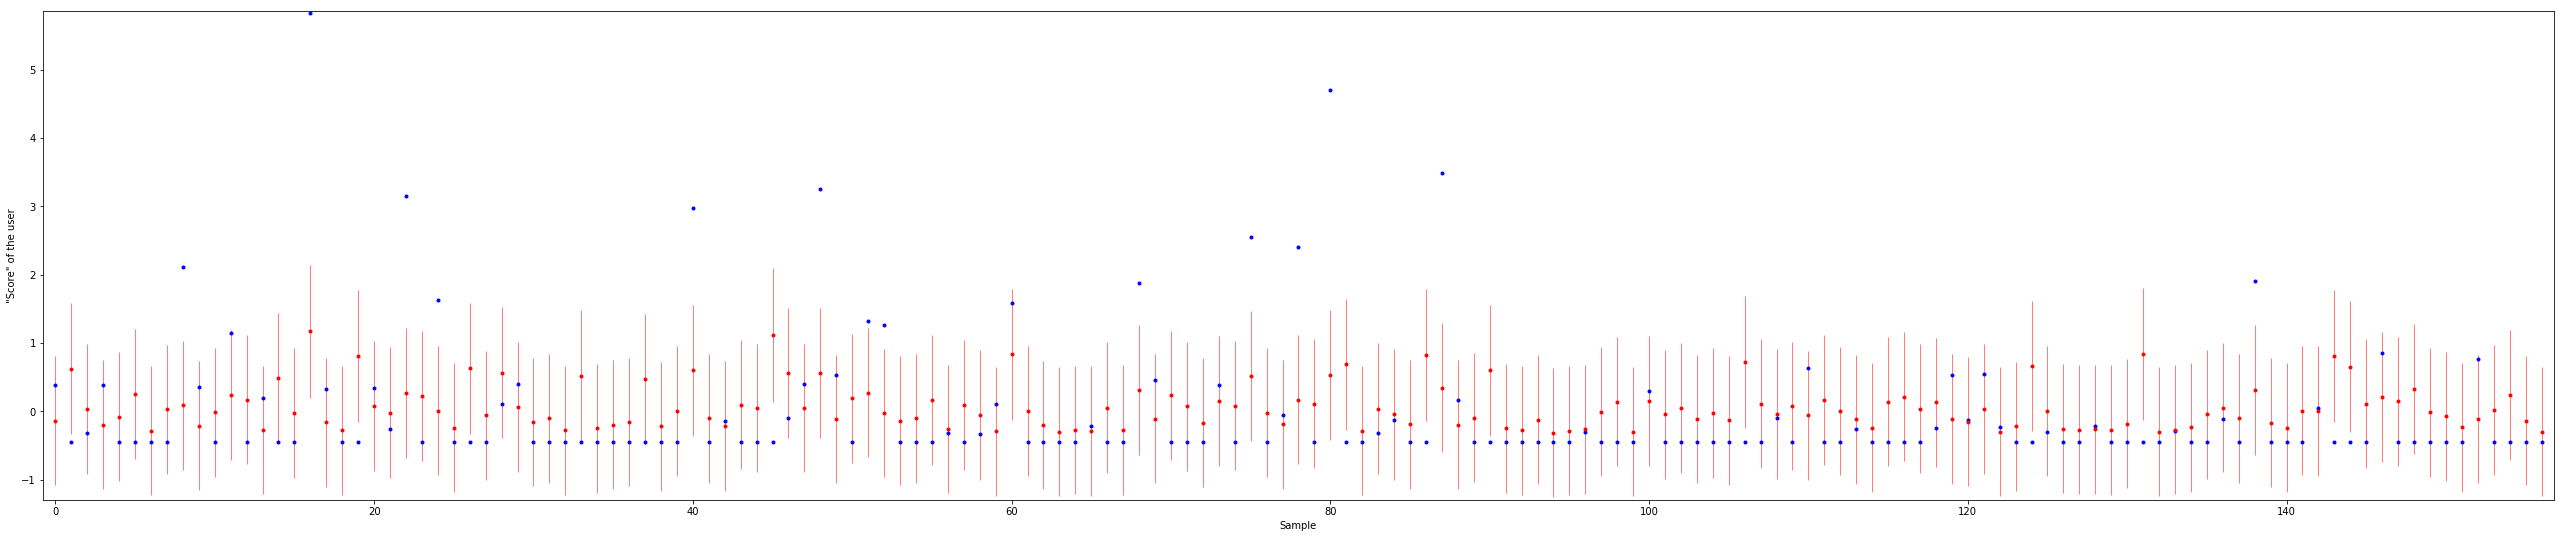

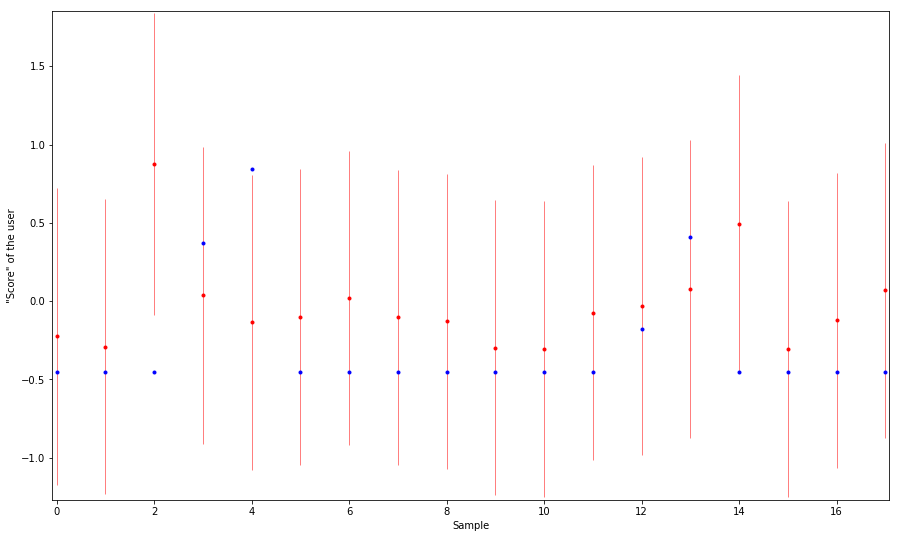

In [23]:
plt.figure(figsize=(45, 9))
plot_prediction_against_truth(y_predict_train, np.sqrt(var_predict_train), y_train)
plt.figure(figsize=(15, 9))
plot_prediction_against_truth(y_predict, np.sqrt(var_predict), y_test)

## LVM

Unfortunately, the LVM does not seem to be able to train due to memory restrictions.

In [2]:
N_latent = 6
N_inducing = 20

def lvm_model_from_kernel(k, X_, opt='scipy', InducingPoints=None, LVM_Params=None):
    try:
        data_mean = LVM_Params[0]
        data_var = LVM_Params[1]
        m = gpflow.models.BayesianGPLVM(X_mean=data_mean, X_var=data_var, Y=X_, kern=k, M=2*N_inducing, Z=InducingPoints)
        assert m is not None
        set_white_variance(m, 1e-3)
        optimize_model(m, opt)
        went_wrong = False
    except (AttributeError, tf.errors.InvalidArgumentError):
        try:
            m1 = gpflow.models.BayesianGPLVM(X_mean=data_mean, X_var=data_var, Y=X_, kern=k, M=2*N_inducing, Z=InducingPoints)
            assert m1 is not None
            set_white_variance(m1, 1e-1)
            print('Trying with higher diagonal jitter (lvm)')
            optimize_model(m1, opt)
            return m1, False
        except (AttributeError, tf.errors.InvalidArgumentError):
            print('The data in this split is not compatible with this kernel (lvm).')
            went_wrong = True
    
    return m, went_wrong

def lvm_cv_model(k, X_, y_, k_name, opt='scipy', split='kfold'):
    errors = list()
    y_predict_train = list()
    var_predict_train = list()
    y_predict = list()
    var_predict = list()
    
    split = kf.split(X_)
    for train, test in split:
        X_train, y_train = X_[train, :], y_[train, :]
        print(X_train)

        if (X_.shape[1] == 18):
            X_train, input_norm = scale(X_train)
            #X_test, _ = scale(X_test, normalisation=input_norm)
        elif (X_.shape[1] == 17):
            X_train, input_norm = scale(X_train, df=X_no_open)
            #X_test, _ = scale(X_test, df=X_no_open, normalisation=input_norm)

        data_mean = gpflow.models.PCA_reduce(X_train, N_latent)
        data_var = 0.1 * np.ones((data_mean.shape[0], N_latent))
        
        data_medoids = data_mean[kMedoids(pairwise_distances(data_mean), N_inducing, 40)[0], :]
        data_archetypes = archetypal_analysis(data_mean, N_inducing)
        Z = np.concatenate((data_medoids, data_archetypes), axis=0)

        errors_for_fold = list()
        for i in range(1):
            if isinstance(k, gpflow.kernels.Linear):
                k.variance = random_initialize(k.variance.value)
            if (isinstance(k, gpflow.kernels.RBF) or isinstance(k, gpflow.kernels.Matern32) or isinstance(k, gpflow.kernels.Matern52))  and not isinstance(k.lengthscales.value, float):
                k.lengthscales = random_initialize(k.lengthscales.value)
                k.variance = random_initialize(k.variance.value)
            if hasattr(k, 'kernels'):
                for i in range(len(k.kernels)):
                    if isinstance(k.kernels[i], gpflow.kernels.Linear):
                        k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)
                    if isinstance(k.kernels[i], gpflow.kernels.RBF) or isinstance(k.kernels[i], gpflow.kernels.Matern32) or isinstance(k.kernels[i], gpflow.kernels.Matern52):
                        k.kernels[i].lengthscales = random_initialize(k.kernels[i].lengthscales.value)
                        k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)

            with gpflow.defer_build():
                lvm_model, error = lvm_model_from_kernel(k, X_train, opt, Z, (data_mean, data_var))

            if not error: 
                latent_X_train = m.X_mean.read_value()
                print(latent_X_train)
                models = list()
                for i in range(1):
                    if isinstance(k, gpflow.kernels.Linear):
                        k.variance = random_initialize(k.variance.value)
                    if (isinstance(k, gpflow.kernels.RBF) or isinstance(k, gpflow.kernels.Matern32) or isinstance(k, gpflow.kernels.Matern52))  and not isinstance(k.lengthscales.value, float):
                        k.lengthscales = random_initialize(k.lengthscales.value)
                        k.variance = random_initialize(k.variance.value)
                    if hasattr(k, 'kernels'):
                        for i in range(len(k.kernels)):
                            if isinstance(k.kernels[i], gpflow.kernels.Linear):
                                k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)
                            if isinstance(k.kernels[i], gpflow.kernels.RBF) or isinstance(k.kernels[i], gpflow.kernels.Matern32) or isinstance(k.kernels[i], gpflow.kernels.Matern52):
                                k.kernels[i].lengthscales = random_initialize(k.kernels[i].lengthscales.value)
                                k.kernels[i].variance = random_initialize(k.kernels[i].variance.value)
                    with gpflow.defer_build():
                        models = models + cv_model(k, latent_X_train, y_train,  'Inner ' + k_name, 'gpr', opt, split='none')
                
                for r_model in models:
                    y_predict_train, var_predict_train = r_model.predict_y(latent_X_train)
                    y_predict, var_predict = r_model.predict_y(X_test)
                    
                    mse = mean_squared_error(y_test, y_predict)
                
                    if (len(errors) == 0 or mse <= min(errors)):
                        best_m = m
                        best_y_train = y_train
                        best_y_test = y_test
                        best_y_predict_train = y_predict_train
                        best_var_predict_train = var_predict_train
                        best_y_predict = y_predict
                        best_var_predict = var_predict

                    errors_for_fold.append(mse)

        errors.append(min(errors_for_fold))
        print("Mean squared error is {0:.3f} for the {1} kernel\n".format(np.mean(errors), k_name))
        return best_m, (best_y_predict_train, best_var_predict_train, best_y_train), (best_y_predict, best_var_predict, best_y_test)

In [ ]:
M = N_latent
linear_kernel = gpflow.kernels.Linear(M, ARD=True)
rbf_kernel = gpflow.kernels.RBF(M, ARD=True) + gpflow.kernels.White(M)
m, _, _ = lvm_cv_model(rbf_kernel, X, y, 'LVM Linear')